# **SET-UP**

In this section, the relavant libraries are imported, and the training, validation and test datasets are prepared.

If the notebook is running on Google Colab, the data can be downloaded to the environment by running the corresponding cell.

In [2]:
# imports

import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

### Download Data into Google Colab Environment

This cell should only be executed if the notebook is running on Google Colab.

If the notebook is running locally with the data already situated in the correct directory, this cell block should **not** be run.

In [3]:
# download if zip files not already downloaded
if not os.path.exists('data.zip'):
    !gdown '1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW'
else:
    print('data.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('data'):
    !unzip -qq data.zip
    !rm data.zip
else:
    print('data folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW
From (redirected): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW&confirm=t&uuid=fd214c0a-7a45-4f79-b502-b20446283a1f
To: /content/data.zip
100% 289M/289M [00:03<00:00, 75.8MB/s]


In [4]:
# download if zip files not already downloaded
if not os.path.exists('utils.zip'):
    !gdown '1TVuiFbjDuPtUh2HFGHCKTXnKcFBH57H0'
else:
    print('utils.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('utils'):
    !unzip -qq utils.zip
    !rm utils.zip
else:
    print('utils folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1TVuiFbjDuPtUh2HFGHCKTXnKcFBH57H0
To: /content/utils.zip
100% 3.20k/3.20k [00:00<00:00, 12.1MB/s]


In [5]:
# download if zip files not already downloaded
if not os.path.exists('depth_estimation.zip'):
    !gdown '1rnUlmkwGfT-RLhT4QK5vtom6mnE-t3aD'
else:
    print('depth_estimation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('depth_estimation'):
    !unzip -qq depth_estimation.zip
    !rm depth_estimation.zip
else:
    print('depth_estimation folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1rnUlmkwGfT-RLhT4QK5vtom6mnE-t3aD
From (redirected): https://drive.google.com/uc?id=1rnUlmkwGfT-RLhT4QK5vtom6mnE-t3aD&confirm=t&uuid=7fe8a471-3831-436d-a0b9-943af775230d
To: /content/depth_estimation.zip
100% 53.3M/53.3M [00:00<00:00, 99.2MB/s]


## Constructing Datasets

Informally experimenting with various batch sizes,demonstrated that a batch size of four yielded the best results.

In [6]:
# batch size
B = 4

The appropriate transformations can be applied for training, validation and test data. The dataset is split into 60% for training data, 10% for validation data, and 30% for test data.

In [7]:
from torch.utils.data import random_split, DataLoader
from utils.vid_dataset import VideoSeqDataset
from utils.data_management import get_transform, initialize_loader

# set up dataset

dataset = VideoSeqDataset(root_dir="data", transform=None, seq_len=5,frame_gap=1)

# picking out the sizes
train_size = int(0.6 * len(dataset))              # 60% for training
val_size = int(0.1 * len(dataset))                # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# dataloaders
train_loader = initialize_loader(train_dataset, get_transform("standard"), B, True)
val_loader = initialize_loader(val_dataset, get_transform("standard"), B, False)
test_loader = initialize_loader(test_dataset, get_transform("standard"), B, False)

### Visualize Data

This cell can be optionally executed to visualize the structure of the dataset.

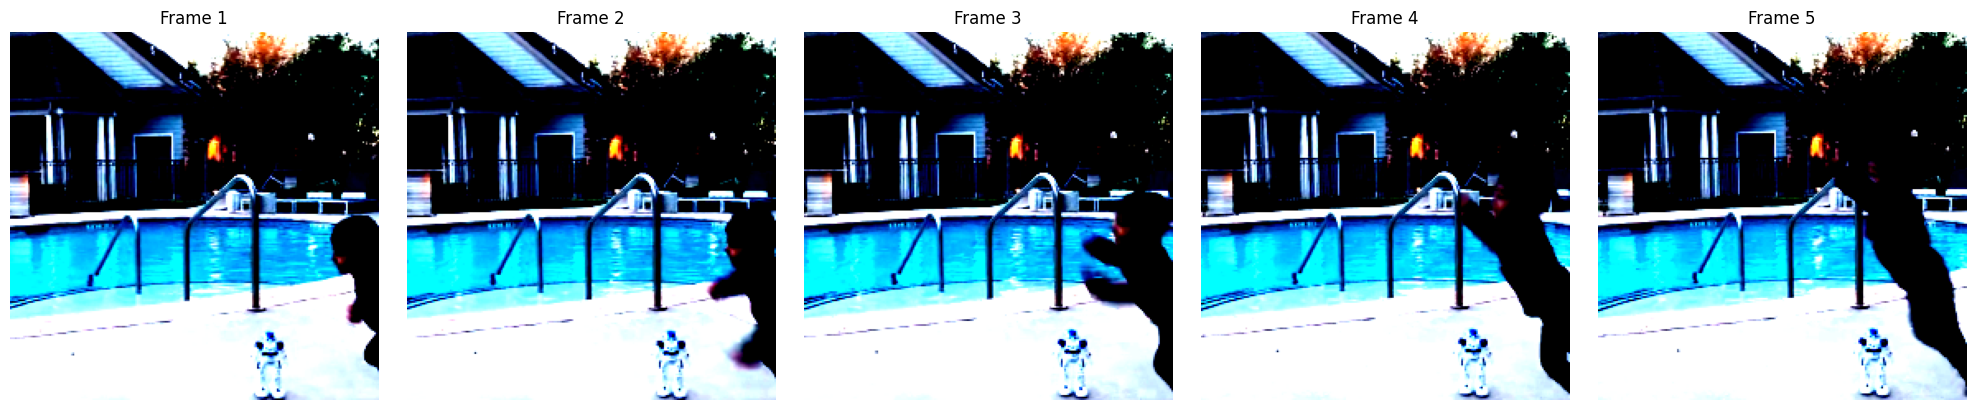

In [8]:
images = train_dataset[5]
plt.figure(figsize=(20, 4))

for i in range(5):
    plt.subplot(1, 5, (i+1))
    plt.title(f"Frame {i+1}")
    plt.imshow(images[i].permute(1, 2, 0).numpy().clip(0,1))
    plt.axis('off')

plt.tight_layout()
plt.show()

# **TOOLS**

#### Helpers

In [9]:
from depth_estimation.depth_net import DepthNet
from depth_estimation.pose_net import PoseNet

def load_depth():
    depth = DepthNet()
    depth.load_state_dict(torch.load("depth_estimation/weights/depth_B.pth", map_location=torch.device('cpu')))
    depth.eval()
    return depth

def load_pose():
    pose = PoseNet()
    pose.load_state_dict(torch.load("depth_estimation/weights/pose_B.1.pth", map_location=torch.device('cpu')))
    pose.eval()
    return pose

def load_backbone():
    backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
    backbone.eval()
    return backbone

In [10]:
import torch

# converts 6D pose vector into a transformation matrix (rotation + translation)
def pose_vec2mat(vec):
    # extract translation vector
    t = vec[:, :3].unsqueeze(-1)

    # extract rotation vector
    angle = vec[:, 3:]

    # normalize to compute values
    angle_norm = torch.norm(angle, dim=1, keepdim=True)
    axis = angle / (angle_norm + 1e-8)  # rotation axis
    angle = angle_norm.unsqueeze(-1)    # angle

    # compute cross product matrices for each batch
    cross = torch.zeros(vec.shape[0], 3, 3).to(vec.device)
    cross[:, 0, 1] = -axis[:, 2]
    cross[:, 0, 2] = axis[:, 1]
    cross[:, 1, 0] = axis[:, 2]
    cross[:, 1, 2] = -axis[:, 0]
    cross[:, 2, 0] = -axis[:, 1]
    cross[:, 2, 1] = axis[:, 0]

    # rotation matrix calculation
    R = torch.eye(3, device=vec.device).unsqueeze(0) + \
        torch.sin(angle) * cross + \
        (1 - torch.cos(angle)) * torch.bmm(cross, cross)

    # arbitrary bottom row for matrix
    btm = torch.tensor([0, 0, 0, 1], device=vec.device).view(1, 1, 4).repeat(vec.shape[0], 1, 1)

    # construct final 4x4 transformation matrix
    T = torch.cat([R, t], dim=-1)                    # concatenate rotation + translation -> 3x4
    transformation_mtx = torch.cat([T, btm], dim=1)  # concatenate bottom row -> 4x4

    return transformation_mtx

# projects pixels from one frame into another view using depth map and camera pose
def project_3d(depth, intrinsics, pose):
    # extract values from depth map
    b, _, h, w = depth.shape

    # create pixel grid
    grid_x, grid_y = torch.meshgrid(torch.arange(w), torch.arange(h), indexing='xy')

    # stack into homogenous coordinates (x, y, 1)
    ones = torch.ones_like(grid_x)
    pixels = torch.stack([grid_x, grid_y, ones], dim=0).float().to(depth.device)

    # flatten pixel grid -> (B, 3, H*W)
    pixels = pixels.view(3, -1).unsqueeze(0).repeat(b, 1, 1)

    # convert to 3D camera coordinates
    cam_points = torch.inverse(intrinsics).bmm(pixels) * depth.view(b, 1, -1)

    # convert to homogenous 3D points -> (B, 4, H*W)
    cam_points = torch.cat([cam_points, torch.ones_like(cam_points[:, :1])], dim=1)

    # compute full projection matrix and project 3D points into new view
    proj = intrinsics.bmm(pose[:, :3, :])
    coords = proj.bmm(cam_points)

    # convert to pixel coordinates using homogenous normalization
    x = coords[:, 0] / (coords[:, 2] + 1e-7)
    y = coords[:, 1] / (coords[:, 2] + 1e-7)

    # normalize coordinates to [-1, 1] range
    x = 2 * (x / w - 0.5)
    y = 2 * (y / h - 0.5)

    # construct grid of warped coordinates
    grid = torch.stack([x, y], dim=-1).view(b, h, w, 2)

    return grid

# set image range back to [0, 1] for loss calculations
def standardize_range(img):
    # reverse of initial transformation tensors used
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(img.device)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(img.device)

    # back to [0, 1]
    return img * imagenet_std + imagenet_mean

#### Object Detection

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# slot attention module with fixed S=10 slots
class SlotAttention(nn.Module):
    def __init__(self, num_slots: int, dim: int, iters: int = 3, mlp_hidden: int = 256):
        super().__init__()
        # fixed variables
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5

        # computation
        self.avg = nn.Parameter(torch.randn(1, 1, dim))
        self.logvar = nn.Parameter(torch.zeros(1, 1, dim))

        # attention layers
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim+1, dim, bias=False)
        self.to_v = nn.Linear(dim+1, dim, bias=False)

        # refinement layers
        self.gru = nn.GRUCell(dim, dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden), nn.ReLU(inplace=True), nn.Linear(mlp_hidden, dim)
        )

        # norm layers
        self.norm_inputs = nn.LayerNorm(dim+1)
        self.norm_slots  = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)

    # initialize slots with noise
    def intialize_slots(self, B):
        mu = self.avg.expand(B, self.num_slots, -1)
        sigma = self.logvar.exp().expand(B, self.num_slots, -1)
        noise = torch.randn_like(mu)
        return mu + sigma * noise

    # attention computation
    def compute_attn(self, q, k):
        logits = torch.einsum('bsc,bnc->bsn', q, k) * self.scale
        attn = logits.softmax(dim=1) + 1e-8
        attn = attn / attn.sum(dim=2, keepdim=True)
        return attn

    def forward(self, feats: torch.Tensor):
        B,N,C_in = feats.shape
        C = self.to_q.out_features

        # initialize slots
        slots = self.intialize_slots(B)

        # keys, values
        k = self.to_k(self.norm_inputs(feats))
        v = self.to_v(feats)

        # attention
        for _ in range(self.iters):
            slots_prev = slots
            q = self.to_q(self.norm_slots(slots))
            attn = self.compute_attn(q, k)
            updates = torch.einsum('bsn,bnc->bsc', attn, v)

            slots = self.gru(updates.reshape(-1, C), slots_prev.reshape(-1, C)).view(B,-1,C)
            slots = slots + self.mlp(self.norm_pre_ff(slots))

        return slots

# mask decoder
class MaskDecoder(nn.Module):
    def __init__(self, feat_dim: int, slot_dim: int):
        super().__init__()
        # project slots to feature space
        self.slot_proj = nn.Linear(slot_dim, feat_dim+1)

    def forward(self, slots: torch.Tensor, feat_map: torch.Tensor) -> torch.Tensor:
        # get shapes
        B,S,D = slots.shape
        B,C,H,W = (4, 768, 16, 16)

        # project slots
        q = self.slot_proj(slots)

        # compute attention
        attn = torch.einsum('bsc,bnc->bsn', q, feat_map)
        attn = attn.softmax(dim=1)

        # reshape to spatial masks
        masks = attn.view(B,S,H,W)
        return masks


# object detection module
class ObjectDetector(nn.Module):
    def __init__(self, num_slots, feat_dim):
        super().__init__()
        self.feat_dim = feat_dim
        self.dino = load_backbone()
        self.depth_net = load_depth()
        self.slot_attn = SlotAttention(num_slots, feat_dim)
        self.mask_decoder = MaskDecoder(feat_dim, feat_dim)
        self.num_slots = num_slots

    # construct feature vector with masks and depth
    @staticmethod
    def compute_object_features(feat_map_flat, depth_flat, masks_flat):
        obj_feats = torch.einsum("bsh,bch->bsc", masks_flat, feat_map_flat)
        obj_feats = obj_feats / (masks_flat.sum(dim=-1, keepdim=True) + 1e-8)
        masked_depth = torch.einsum("bsh,bch->bsc", masks_flat, depth_flat)
        masked_depth = masked_depth / (masks_flat.sum(dim=-1, keepdim=True) + 1e-8)
        obj_feats = torch.cat([obj_feats, masked_depth], dim=-1)
        return obj_feats

    # compute confidence score from masks and bounding boxes
    @staticmethod
    def compute_confidence(masks, bboxes, min_area=5):
        B, S, H, W = masks.shape
        flat_masks = masks.view(B, S, -1)

        # activation
        avg_score = flat_masks.mean(dim=-1)
        peak_score = flat_masks.max(dim=-1).values

        # bbox area check
        widths = (bboxes[..., 2] - bboxes[..., 0]).clamp(min=0)
        heights = (bboxes[..., 3] - bboxes[..., 1]).clamp(min=0)
        box_area = widths * heights
        valid_box = (box_area > min_area).float()

        # weighted sum
        confidence = 0.6 * avg_score + 0.4 * peak_score
        confidence = confidence * valid_box

        return confidence

    # move all models to device
    def set_device(self, device):
        self.to(device)
        self.dino.to(device)
        self.depth_net.to(device)
        self.slot_attn.to(device)
        self.mask_decoder.to(device)

    # use backbone to get image features
    def extract_features(self, img):
        flat = self.dino.get_intermediate_layers(img, n=1)[0]
        B, N, C = flat.shape
        H = W = int(N ** 0.5)
        features = flat.transpose(1, 2).reshape(B, C, H, W)
        return flat, features

    # get depth
    def get_depth(self, img):
        return self.depth_net(img)

    # get pose
    def get_pose(self, img):
        return pose_vec2mat(self.pose_net(img))

    # get masks from slot attention + mask decoder
    def get_masks(self, feat, depth):
        B = feat.shape[0]
        depth_feats = torch.cat([feat, depth], dim=-1)
        slots = self.slot_attn(depth_feats)
        masks = self.mask_decoder(slots, depth_feats)
        masks_flat = masks.view(B, self.num_slots, -1)
        return slots, masks, masks_flat

    # use masks to compute bounding boxes
    def get_bounding_boxes(self, masks):
        # storing bounding boxes for slots
        bboxes = []
        B = masks.shape[0]

        # iterate over batches
        for b in range(B):
            boxes_batch = []
            for s in range(self.num_slots):
                # nonzero pixels
                mask = masks[b, s]
                ys, xs = torch.where(mask > 0.5 * mask.max())

                if len(xs) == 0 or len(ys) == 0:
                    # empty masks
                    boxes_batch.append(torch.tensor([0,0,0,0], device=mask.device))
                else:
                    # min max corners
                    x1, x2 = xs.min().item(), xs.max().item()
                    y1, y2 = ys.min().item(), ys.max().item()
                    boxes_batch.append(torch.tensor([x1, y1, x2, y2], device=mask.device))

            # stack batch boxes
            bboxes.append(torch.stack(boxes_batch))

        # stack all batches
        bboxes = torch.stack(bboxes)
        return bboxes

    # forward pass
    def forward(self, x):
        B = x.shape[0]

        # get features
        feat_map_flat, feat_map = self.extract_features(x)

        # get depth and prep for processing
        depth = self.get_depth(x)
        depth_down = F.interpolate(depth, size=(16, 16), mode='bilinear', align_corners=False)
        depth_flat = depth_down.view(B, 1, -1)

        # get final values
        slots, masks, masks_flat = self.get_masks(feat_map_flat, depth_flat.permute(0, 2, 1))
        obj_feats = self.compute_object_features(feat_map_flat.view(B, 768, -1), depth_flat, masks_flat)
        bboxes = self.get_bounding_boxes(masks)
        conf = self.compute_confidence(masks, bboxes)
        return feat_map, depth, slots, masks, bboxes, obj_feats, conf

#### Scene Graph Construction

In [12]:
import torch
import torch.nn as nn

class SceneGraphConstructor(nn.Module):
    def __init__(self, node_dim=256, edge_dim=128, device='cuda'):
        super().__init__()
        self.device = device
        self.intrinsics = torch.eye(3).repeat(1, 1).to(device)

        # node mlp
        self.node_mlp = nn.Sequential(
            nn.Linear(768 + 769 + 4 + 1 + 3, 512),
            nn.ReLU(),
            nn.Linear(512, node_dim))

        # edge mlp
        self.edge_mlp = nn.Sequential(
            nn.Linear(2*node_dim, 256),
            nn.ReLU(),
            nn.Linear(256, edge_dim))

    # edge feature vector construction
    @staticmethod
    def edge_features(node_emb):
        B, N, D = node_emb.shape
        n_i = node_emb.unsqueeze(2).expand(B, N, N, D)
        n_j = node_emb.unsqueeze(1).expand(B, N, N, D)
        edge_feat = torch.cat([n_i, n_j], dim=-1)
        return edge_feat

    # pool masks and features
    def mask_pooling(self, features, masks):
        B, C, H, W = features.shape
        N = masks.shape[1]

        # flatten spatial dims
        features_flat = features.view(B, C, H*W)
        masks_flat = masks.view(B, N, H*W)

        # normalize mask
        masks_norm = masks_flat / (masks_flat.sum(dim=-1, keepdim=True) + 1e-6)

        # weighted sum
        pooled = torch.einsum('bnh,bch->bnc', masks_norm, features_flat)
        return pooled

    # position feature vector
    def positional_encoding(self, bboxes):
        # compute center
        x1, y1, x2, y2 = bboxes.unbind(-1)
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        # find dimensions
        w = x2 - x1
        h = y2 - y1

        # construct feature
        pos_feat = torch.stack([cx, cy, w, h], dim=-1)
        return pos_feat

    # position in next frame
    def motion_prior(self, masks, depth, pose, K):
        B, N, H, W = masks.shape
        device = masks.device

        # pixel coordinate centroid
        ys = torch.arange(H, device=device).view(1, 1, H, 1).expand(B, N, H, W)
        xs = torch.arange(W, device=device).view(1, 1, 1, W).expand(B, N, H, W)
        mask_sum = masks.sum([-1,-2]) + 1e-6
        cx = (masks * xs).sum([-1,-2]) / mask_sum
        cy = (masks * ys).sum([-1,-2]) / mask_sum

        # depth at centroid
        cx_idx = cx.round().long().clamp(0, W-1)
        cy_idx = cy.round().long().clamp(0, H-1)

        # collect
        batch_idx = torch.arange(B, device=device).view(B,1).expand(B,N)
        z = depth[batch_idx, 0, cy_idx, cx_idx]

        # 3D coordinates in camera frame
        X = (cx - K[0,2]) * z / K[0,0]
        Y = (cy - K[1,2]) * z / K[1,1]
        P_3D = torch.stack([X, Y, z], dim=-1)

        # homogeneous coordinates and transform to next frame
        P_h = torch.cat([P_3D, torch.ones(B, N, 1, device=device)], dim=-1)
        P_next = torch.einsum('bij,bnj->bni', pose, P_h)
        P_next = P_next[..., :3] / P_next[..., 3:]

        return P_next

    # forward pass
    def forward(self, obj_feats, masks, features, bboxes, conf, depth, pose):
        # get features
        pooled_feats = self.mask_pooling(features, masks)
        pos_feat = self.positional_encoding(bboxes)
        motion = self.motion_prior(masks, depth, pose, self.intrinsics)

        # node construction
        node_input = torch.cat([pooled_feats, obj_feats, pos_feat, conf.unsqueeze(-1), motion], dim=-1)
        node_emb = self.node_mlp(node_input)

        # edge construction
        edge_feat = self.edge_features(node_emb)
        B, N, _, _ = edge_feat.shape
        edge_emb = self.edge_mlp(edge_feat.view(B, N*N, -1))
        edge_emb = edge_emb.view(B, N, N, -1)

        # soft adjacency matrix
        adj = torch.exp(-torch.cdist(node_emb, node_emb))

        return node_emb, edge_emb, adj


In [13]:
# evolving scene graph: update node and edge embeddings across frames
class EvolvingSceneGraphTemporal(nn.Module):
    def __init__(self, node_dim=256, edge_dim=128, device='cuda'):
        super().__init__()
        # scene graph constructor
        self.sg_constructor = SceneGraphConstructor(node_dim, edge_dim, device)

        # gru to update node embeddings temporally
        self.node_gru = nn.GRUCell(node_dim, node_dim)

        # mlp to compute temporal edge embeddings
        self.temporal_edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim, 256),
            nn.ReLU(),
            nn.Linear(256, edge_dim)
        )

        self.device = device
        self.prev_node_emb = None
        self.prev_edge_emb = None

    # reset previous embeddings
    def reset(self):
        self.prev_node_emb = None
        self.prev_edge_emb = None

    def forward(self, obj_feats, masks, features, bboxes, conf, depth, pose):
        # construct scene graph for current frame
        node_emb, edge_emb, adj = self.sg_constructor(obj_feats, masks, features, bboxes, conf, depth, pose)
        B, N, D = node_emb.shape

        # update nodes with temporal gru if previous exists
        if self.prev_node_emb is not None:
            node_emb_flat = node_emb.view(B * N, D)
            prev_flat = self.prev_node_emb.view(B * N, D)
            node_emb_updated = self.node_gru(node_emb_flat, prev_flat).view(B, N, D)
        else:
            node_emb_updated = node_emb

        # compute current edge embeddings
        edge_feat = self.sg_constructor.edge_features(node_emb_updated)
        edge_emb = self.sg_constructor.edge_mlp(edge_feat.view(B, N * N, -1)).view(B, N, N, -1)

        # compute temporal edges between previous nodes and current nodes
        if self.prev_node_emb is not None:
            prev_i = self.prev_node_emb.unsqueeze(2).expand(B, N, N, D)
            curr_j = node_emb_updated.unsqueeze(1).expand(B, N, N, D)
            temporal_edge_feat = torch.cat([prev_i, curr_j], dim=-1)
            temporal_edge_emb = self.temporal_edge_mlp(temporal_edge_feat.view(B, N * N, -1)).view(B, N, N, -1)
        else:
            temporal_edge_emb = None

        # store current embeddings for next frame
        self.prev_node_emb = node_emb_updated.detach()
        self.prev_edge_emb = edge_emb.detach()

        # adjacency: distance-based similarity
        adj = torch.exp(-torch.cdist(node_emb_updated, node_emb_updated))

        return node_emb_updated, edge_emb, temporal_edge_emb, adj


# **GNN Tracker**

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GNNTracker(nn.Module):
    def __init__(self, node_dim=256, edge_dim=128, hidden_dim=256):
        super().__init__()
        self.node_proj = nn.Linear(node_dim, hidden_dim)
        self.edge_proj = nn.Linear(edge_dim, hidden_dim)
        self.temp_proj = nn.Linear(edge_dim, hidden_dim)
        self.update = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, node_emb, edge_emb, temporal_edge_emb=None):
        B, N, _ = node_emb.shape

        # project
        node_h = self.node_proj(node_emb)
        edge_h = self.edge_proj(edge_emb)

        if temporal_edge_emb is not None:
            temp_h = self.temp_proj(temporal_edge_emb)
            edge_h = edge_h + temp_h

        # aggregate messages
        node_exp = node_h.unsqueeze(1).expand(B, N, N, -1)
        messages = edge_h * node_exp
        messages = messages.sum(dim=2)

        # update nodes with GRU
        node_h = self.update(messages.reshape(-1, messages.size(-1)),
                             node_h.reshape(-1, node_h.size(-1)))
        node_h = node_h.view(B, N, -1)

        return node_h, edge_h


# **DEMONSTRATION**

#### helpers

In [52]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import numpy as np

def visualize_scene_graph(image, bboxes, in_masks, node_emb, edge_emb, temporal_edge_emb=None, title=""):
    N = node_emb.shape[0]
    H, W = image.shape[1], image.shape[2]
    img_np = image.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img_np)
    for i, box in enumerate(bboxes.cpu().numpy()):
        x1, y1, x2, y2 = box.astype(int)
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor="red")
        axs[0].add_patch(rect)
        axs[0].text(x1, y1-2, f"O{i}", color="yellow", fontsize=8)
    axs[0].set_title("Frame with boxes")

    masks = F.interpolate(in_masks.unsqueeze(1).float(), size=(224, 224),
                             mode="bilinear", align_corners=False).squeeze(1)
    mask_overlay = img_np.copy()
    colors = plt.cm.tab10(np.linspace(0,1,N))

    for i, mask in enumerate(masks.cpu().numpy()):
        mask_bool = mask > 0.5
        mask_overlay[mask_bool] = colors[i,:3]
    axs[1].imshow(mask_overlay)
    axs[1].set_title("Masks overlay")

    G = nx.DiGraph()
    for i in range(N):
        G.add_node(i)
    # spatial edges
    for i in range(N):
        for j in range(N):
            if i != j and edge_emb[i,j].abs().sum() > 1e-5:
                G.add_edge(i,j, color="blue")
    # temporal edges
    if temporal_edge_emb is not None:
        for i in range(N):
            for j in range(N):
                if i != j and temporal_edge_emb[i,j].abs().sum() > 1e-5:
                    G.add_edge(i,j, color="green")

    node_2d = PCA(n_components=2).fit_transform(node_emb.detach().cpu().numpy())
    pos = {i: node_2d[i] for i in range(N)}
    colors = ["orange"]*N
    edge_colors = [G[u][v]["color"] for u,v in G.edges]

    nx.draw(G, pos, ax=axs[2], node_color=colors, edge_color=edge_colors,
            with_labels=True, font_size=8, node_size=300)
    axs[2].set_title("Scene graph (blue=spatial, green=temporal)")

    fig.suptitle(title)
    plt.show()


### load models

In [19]:
from utils.visual_helpers import plot_train_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
pose_net = load_pose()
pose_net.to(device)

obj_detector = ObjectDetector(10, 768)
obj_detector.set_device(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 264MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [37]:
sg_evolving = EvolvingSceneGraphTemporal(node_dim=256, edge_dim=128, device=device)
sg_evolving.reset()

In [55]:
gnn = GNNTracker(node_dim=256, edge_dim=128, hidden_dim=256).to(device)

### run example

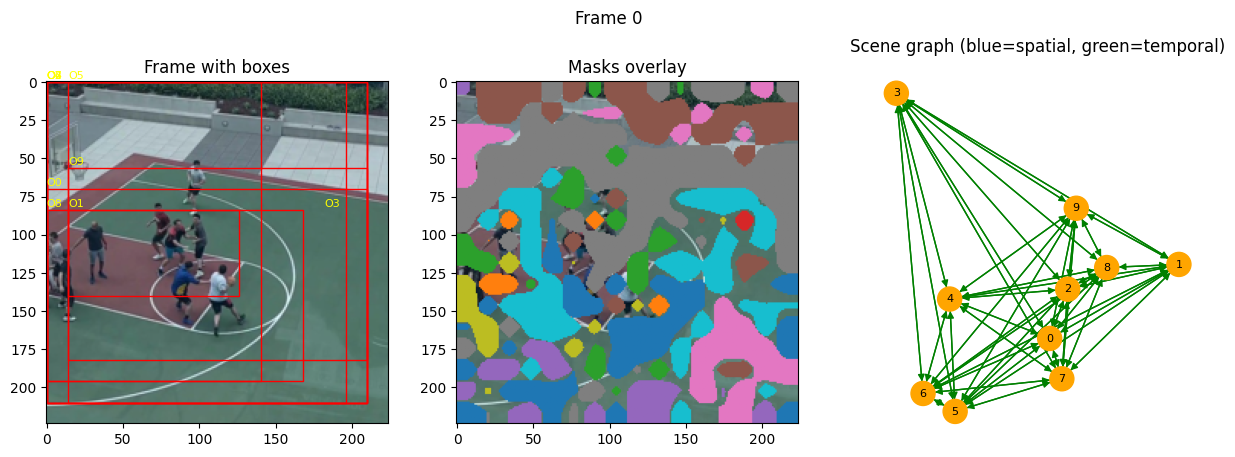

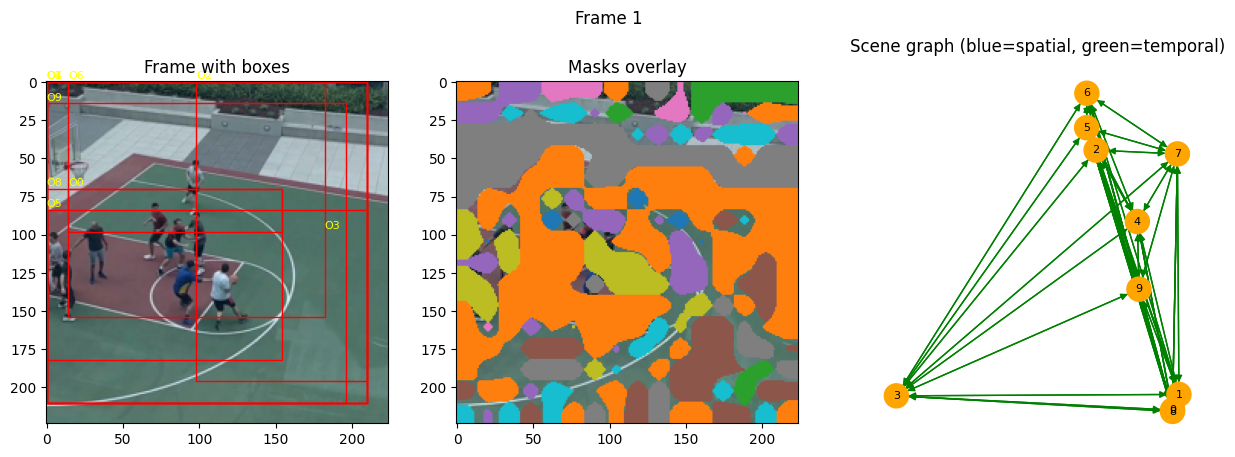

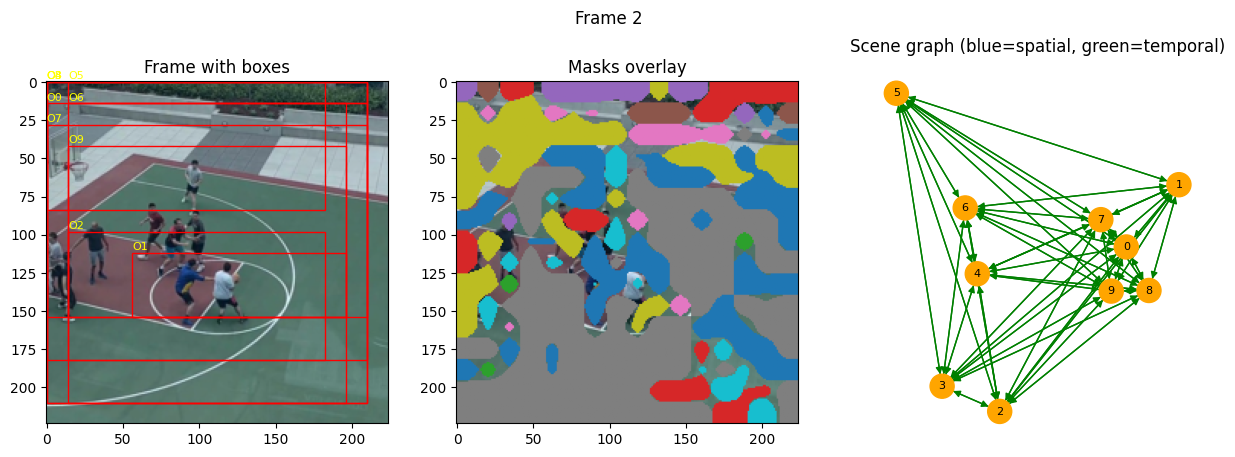

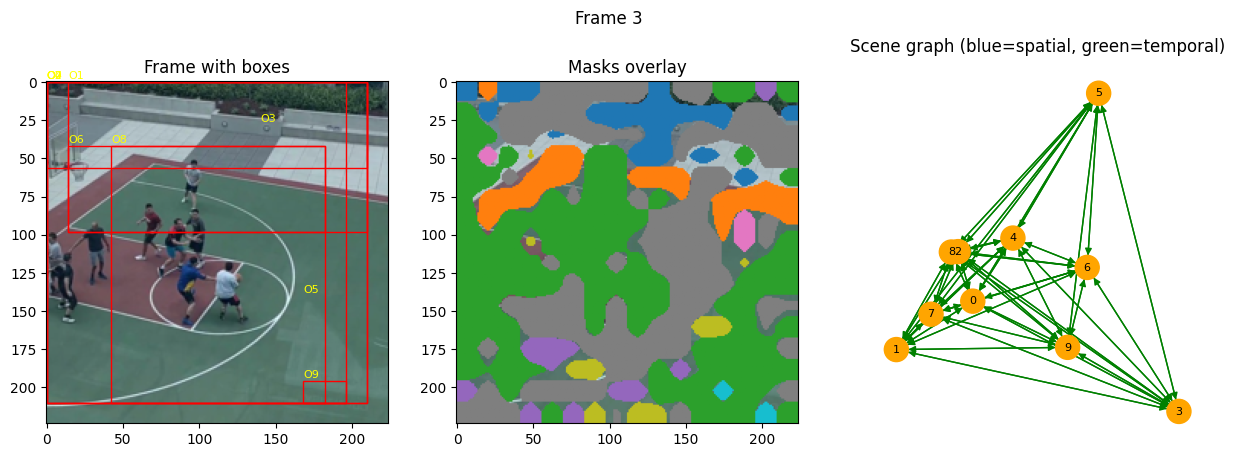

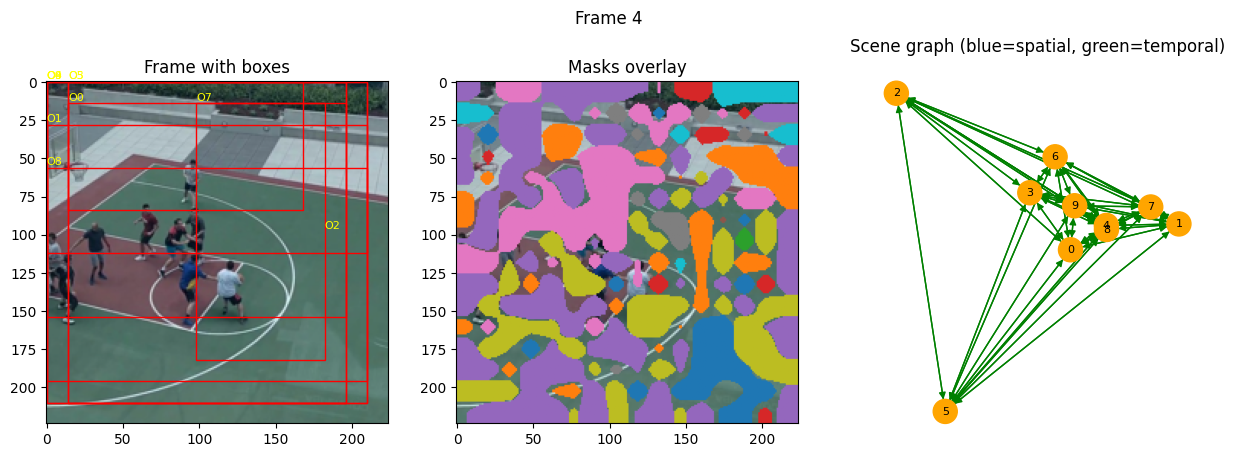

In [50]:
prev_bboxes = None

with torch.no_grad():
    for vid in train_loader:
        prev_bboxes = None

        for i in range(5):
            tgt = vid[:, i, :, :, :]
            src = vid[:, i-1, :, :, :] if i > 0 else tgt

            depth = obj_detector.get_depth(tgt)
            pose = pose_vec2mat(pose_net(tgt, src))
            features, depth, slots, masks, bboxes, obj_feats, conf = obj_detector(tgt)

            node_emb, edge_emb, temporal_edge_emb, adj = sg_evolving(
                obj_feats, masks, features, bboxes, conf, depth, pose
            )

            node_ref, edge_ref = gnn(node_emb, edge_emb, temporal_edge_emb)

            # Take first image in batch
            visualize_scene_graph(
                tgt[0], bboxes[0]*(224//16), masks[0], node_ref[0], edge_ref[0],
                temporal_edge_emb[0] if temporal_edge_emb is not None else None,
                title=f"Frame {i}"
            )
        break